# <ins>Movie Recommendation System</ins>
Building a movie recommendation system that gives the user their top 5 movie recommendations based on their rating profiles. 

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import pairwise_distances
import surprise
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import knns
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# loading csv's into dataframes
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
movies = pd.read_csv('movies.csv')
links = pd.read_csv('links.csv')

## Content of Files

**ratings:** 
- Each row represents one rating of one movie by one user
- Ratings are made on a 5-star scale, with half-star increments 

**tags:** 
- Each row represents one tag applied to one movie by one user
- Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user

**movies:** 
- Each row represents one movie
- Movie titles are entered manually or imported from https://www.themoviedb.org/, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles

**links:** 
- Identifiers that can be used to link to other sources of movie data; each row represents one movie


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# merging movie and rating dataframes 
df = ratings.merge(movies,on='movieId', how='left')

In [7]:
# dropping timestamp column
df.drop(columns = 'timestamp',inplace=True)

# <ins>EDA</ins>

In [8]:
df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


## Genres

In [9]:
# creating dictionary of genres 
genres = []
for row in df['genres']: 
    genres.extend(row.split('|'))
genre_dict = {}
for genre in genres:
    if genre in genre_dict: 
        genre_dict[genre] += 1
    else:
        genre_dict[genre] = 1
# creating df 
genres = {'Genre': list(genre_dict.keys()), 'Count': list(genre_dict.values())}
genre_df = pd.DataFrame(genres)
sorted_genres = genre_df.sort_values(by='Count',ascending=False)

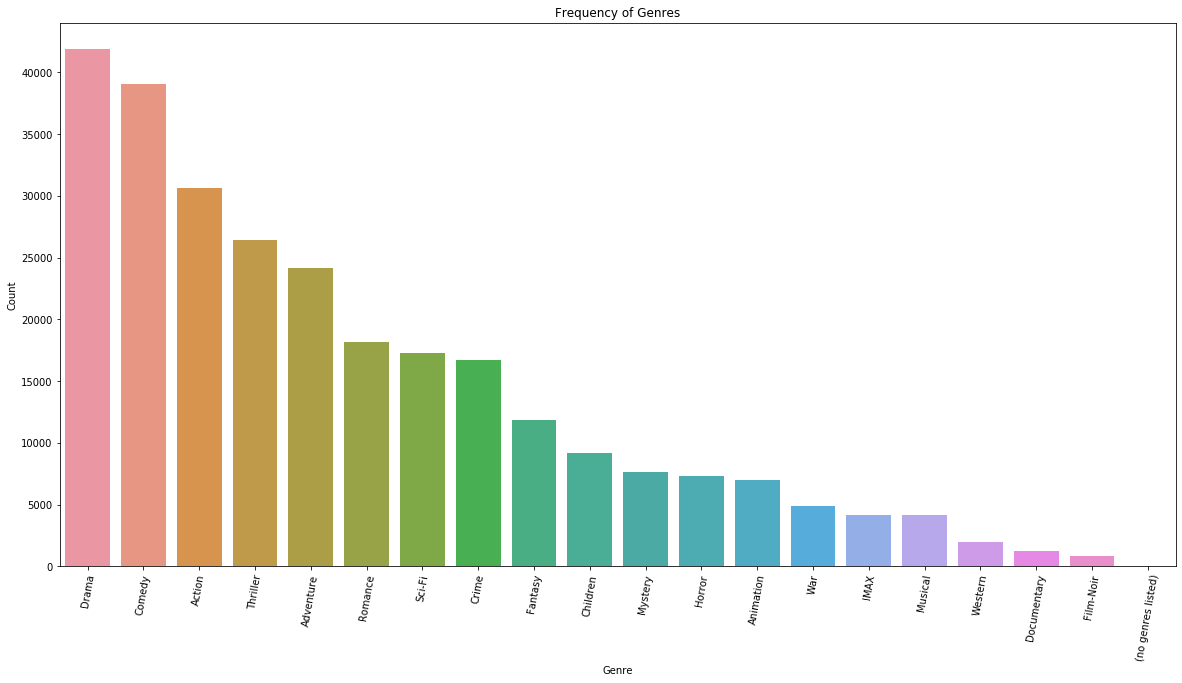

In [10]:
# barplot of genres
x = sorted_genres['Genre']
y = sorted_genres['Count']

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x,y)
sns.barplot(x,y)

ax.set_xticklabels(x,rotation=80)
ax.set_ylabel("Count")
ax.set_title("Frequency of Genres")

plt.savefig('genres.png')

## Ratings

In [11]:
ratings_counts = df['rating'].value_counts().sort_index(ascending = False)

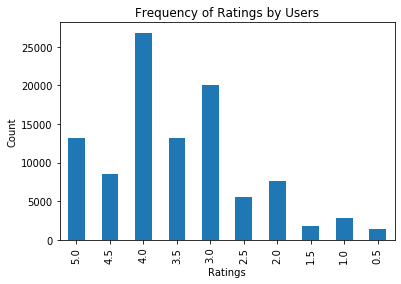

In [12]:
fig, ax = plt.subplots()
ax = ratings_counts.plot(kind="bar")
ax.set_ylabel('Count')
ax.set_xlabel('Ratings')
ax.set_title('Frequency of Ratings by Users')

plt.savefig('ratings.png')

In [13]:
# average ratings per movie 
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: rating, dtype: float64

In [14]:
# looking at rating counts for each movie since the above is being skewed by movies with only 1 or a few ratings by users
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [15]:
# creating a df with title, rating, and rating counts for each movie
ratings_mean_count = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings_mean_count.head()

,rating,rating_counts
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


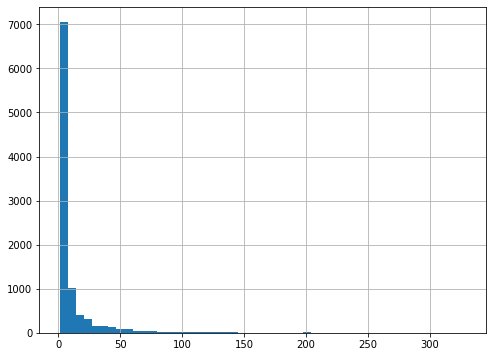

In [63]:
# graph showing that most movies have under 50 ratings
plt.figure(figsize=(8,6))
ratings_mean_count['rating_counts'].hist(bins=50)

plt.savefig('dist_ratings.png')

In [17]:
rating_over50 = ratings_mean_count[ratings_mean_count['rating_counts']>50]
rating_over50.sort_values(by='rating',ascending=False)

,rating,rating_counts
title,,
"Shawshank Redemption, The (1994)",4.429022,317
"Godfather, The (1972)",4.289062,192
Fight Club (1999),4.272936,218
Cool Hand Luke (1967),4.271930,57
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.268041,97
...,...,...
Johnny Mnemonic (1995),2.679245,53
Judge Dredd (1995),2.669355,62
City Slickers II: The Legend of Curly's Gold (1994),2.645455,55


# <ins>Simple Recommendation System</ins>

In [18]:
# matrix of movie titles and their user ratings 
user_movie_rating = df.pivot_table(index='userId', columns='title', values='rating')
user_movie_rating.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# looking at Toy Story's correlation with all other movies 
correlations = user_movie_rating.corrwith(user_movie_rating['Toy Story (1995)'])
recommendation = pd.DataFrame(correlations,columns=['Correlation'])
recommendation.dropna(inplace=True)
recommendation = recommendation.join(ratings_mean_count['rating_counts'])
recommendation.head()

,Correlation,rating_counts
title,,
"'burbs, The (1989)",0.240563,17
(500) Days of Summer (2009),0.353833,42
*batteries not included (1987),-0.427425,7
10 Cent Pistol (2015),1.000000,2
10 Cloverfield Lane (2016),-0.285732,14


In [65]:
# sorting movies correlated with Toy Story with at least 100 ratings
recc = recommendation[recommendation['rating_counts']>100].sort_values('Correlation',ascending=False).reset_index()
recc = recc.merge(movies,on='title', how='left')
recc.head(6)

,title,Correlation,rating_counts,movieId,genres
0,Toy Story (1995),1.000000,215,1,Adventure|Animation|Children|Comedy|Fantasy
1,"Incredibles, The (2004)",0.643301,125,8961,Action|Adventure|Animation|Children|Comedy
2,Finding Nemo (2003),0.618701,141,6377,Adventure|Animation|Children|Comedy
3,Aladdin (1992),0.611892,183,588,Adventure|Animation|Children|Comedy|Musical
4,"Monsters, Inc. (2001)",0.490231,132,4886,Adventure|Animation|Children|Comedy|Fantasy
5,Mrs. Doubtfire (1993),0.446261,144,500,Comedy|Drama


Now we can see the movies that are highly correlated with Toy Story, however, this is just a very simple recommender system...next I will use collaborative filtering and content-based filtering to find a better model for my recommendation system!

# <ins>Train-Test Split</ins>

In [21]:
# using surprise to create test and train sets
reader = surprise.Reader(rating_scale=(1, 5))
data = surprise.Dataset.load_from_df(df[['userId','title','rating']], reader)
trainset, testset = surprise.model_selection.train_test_split(data, test_size=.25, random_state=42)

# <ins>Collaborative Filtering</ins>

Collaborative filtering uses to information to find similarities between users or items based on their past rating profiles.

**Pros**
- Works on any kind of item and no feature engineering is needed
- Recommendations are relevant since it is based on past users/items rating profiles

**Cons**
- Cold start problem - new user problem
- Sparsity issue - new item problem
- Need high user to item ratio to perform well
- Popularity bias
- Requires user community - the bigger the dataset the more powerful and efficient our model will be

## Item-to-Item Filtering

In [22]:
# using pivot table function to map between movies, users, and ratings
items_ratings_matrix = df.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
items_ratings_matrix.fillna( 0, inplace = True )

In [23]:
items_ratings_matrix.shape

(9724, 610)

In [24]:
# calculating cosine similarity
movie_sim = 1 - pairwise_distances(items_ratings_matrix.as_matrix(), metric="cosine" )
np.fill_diagonal(movie_sim, 0 ) 
items_ratings_matrix = pd.DataFrame(movie_sim)

In [25]:
# setting movie titles as index for our matrix 
items_ratings_matrix['movie'] = movies['title']
items_ratings_matrix.set_index('movie', inplace = True)

In [26]:
# setting titles for matrix columns
items_ratings_matrix.columns = items_ratings_matrix.index

In [27]:
items_ratings_matrix.head(3)

movie,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Dogman (2018),Mamma Mia: Here We Go Again! (2018),Tag (2018),The Man Who Killed Don Quixote (2018),Boundaries (2018),Spiral (2018),Mission: Impossible - Fallout (2018),SuperFly (2018),Iron Soldier (2010),BlacKkKlansman (2018)
movie,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji (1995),0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# creating a function that returns top 5 recommendations based on given movie
def rec_item_to_item(movie_title, items_ratings_matrix):
    '''
    Finds the top 5 movie recommendations using item-to-item filtering.
    
    Parameters:
        movie_title: movie to base recommendations on
        items_ratings_matrix: matrix with cosine similarities
    '''
    for i in items_ratings_matrix.index:
        if movie_title == i:
            return items_ratings_matrix[movie_title].sort_values(ascending= False)[1:6]

In [29]:
print(rec_item_to_item('Fight Club (1999)', items_ratings_matrix))

movie
Million Dollar Baby (2004)              0.765092
Slums of Beverly Hills, The (1998)      0.707107
Hunting of the President, The (2004)    0.707107
Atlantis: The Lost Empire (2001)        0.707107
Point Break (1991)                      0.707107
Name: Fight Club (1999), dtype: float64


### Evaluation

In [30]:
# evaluating item-to-item using pearson and cosine coefficients
sim_pear = {'name':'pearson','user_based':True}
sim_cos = {'name':'cosine','user_based':True}

# fitting the model using KNN - cosine
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)
predictions_knn = basic.test(testset)
print('sim_cos RMSE:', accuracy.rmse(predictions_knn))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9796
sim_cos RMSE: 0.9795887478201124


In [31]:
# fitting the model using KNN - pearson
basic = knns.KNNBasic(sim_options=sim_pear)
basic.fit(trainset)
predictions_knn = basic.test(testset)
print('sim_pear:', accuracy.rmse(predictions_knn))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9836
sim_pear: 0.9836439652122732


## User-to-User Filtering

In [32]:
users_ratings_matrix = df.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
users_ratings_matrix.fillna( 0, inplace = True )
movie_sim = 1 - pairwise_distances(users_ratings_matrix.as_matrix(), metric="cosine" )
np.fill_diagonal(movie_sim, 0 ) #Filling diagonals with 0s for future use when sorting is done
users_ratings_matrix = pd.DataFrame( movie_sim )

In [33]:
users_ratings_matrix.head(3)

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.05972,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.00000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.00000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119


In [34]:
similar_user_series = users_ratings_matrix.idxmax(axis=1)
df_sim_user = similar_user_series.to_frame()
df_sim_user.columns=['similar_user']

In [35]:
def similar_user_rec(user_id,n=5):
    '''
    Takes in a user id then looks at the similar_user df 
    dataframe to check the most similar user. Then it outputs 
    n-number recommendations that are top-rated by this similar user.
    
    Parameters:
        user_id: ID of the person looking for recommendations
        n: number of recommendations 
    
    Returns:
        n-number of recommendations based on the user given 
    
    '''
    similar_user = df_sim_user['similar_user'].iloc[user_id]
    new_df = df.loc[(df['userId'] == similar_user)]
    new_df = new_df.sort_values('rating', ascending=False).head(n)
    rec_list = new_df['title'].to_list()
    return rec_list[0:n+1]

In [36]:
# recommendation for user_id = 24
similar_user_rec(24 ,n=5)

['M*A*S*H (a.k.a. MASH) (1970)',
 'Sound of Music, The (1965)',
 'Oliver! (1968)',
 'My Cousin Vinny (1992)',
 'West Side Story (1961)']

### Evaluation

In [37]:
# evaluating item-to-item using pearson and cosine coefficients
sim_pear = {'name':'pearson','user_based':False}
sim_cos = {'name':'cosine','user_based':False}

# fitting the model using KNN - cosine
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)
predictions_knn = basic.test(testset)
print('sim_cos RMSE:', accuracy.rmse(predictions_knn))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9826
sim_cos RMSE: 0.9826380249221595


In [38]:
# fitting the model using KNN - pearson
basic = knns.KNNBasic(sim_options=sim_pear)
basic.fit(trainset)
predictions_knn = basic.test(testset)
print('sim_pear:', accuracy.rmse(predictions_knn))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9759
sim_pear: 0.9758517160628227


## Model-Based Collaborative Filtering with Surprise

In [39]:
!Pip install scikit-surprise

In [40]:
# dropping timestamp column and converting ratings file to a df
ratings = ratings.drop(columns='timestamp')

In [41]:
# reading in the ratings dataset using surprise
reader = Reader()
data = Dataset.load_from_df(ratings, reader)

In [42]:
# checking how many users and items in our dataset 
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [43]:
# performing gridsearch with SVD
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

In [44]:
# determining best score and params
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8681925385046849, 'mae': 0.6672379439974535}
{'rmse': {'n_factors': 50, 'reg_all': 0.05}, 'mae': {'n_factors': 50, 'reg_all': 0.05}}


In [45]:
# cross validating with KNN basic 
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [46]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.98101008, 0.97015034, 0.97043201, 0.96236136, 0.97973694]))
('test_mae', array([0.75671418, 0.7488287 , 0.74808624, 0.74425431, 0.75852747]))
('fit_time', (0.4154999256134033, 0.3763861656188965, 0.347977876663208, 0.3592710494995117, 0.37369608879089355))
('test_time', (1.253183126449585, 1.1924452781677246, 1.1929891109466553, 1.4036328792572021, 1.29832124710083))
-----------------------
0.972738143721618


In [47]:
# cross validating with KNN baseline 
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [48]:
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.87174046, 0.87831843, 0.87817283, 0.87474407, 0.87496366]))
('test_mae', array([0.66819203, 0.66954241, 0.67046259, 0.66794319, 0.6673809 ]))
('fit_time', (0.6120550632476807, 0.649101972579956, 0.6835167407989502, 0.6647212505340576, 0.7070319652557373))
('test_time', (1.7307848930358887, 1.8668320178985596, 1.6553983688354492, 1.7780210971832275, 1.761343002319336))


0.8755878913697981

The best performing model is SVD with n_factors = 20 and regularization rate of of 0.02. 

I used RMSE to evaluate these models. RMSE is our prediction error which basically tells us how far off our predictions are. The lower the RMSE, the better our model is at predicting.

### Recommendation using SVD

In [49]:
# chose user and some of their preferences 
user_rating = [{'userId': 24, 'movieId': 3902, 'rating': '4.5'},
 {'userId': 24, 'movieId': 3904, 'rating': '4.0'},
 {'userId': 24, 'movieId': 4007, 'rating': '4.0'},
 {'userId': 24, 'movieId': 4009, 'rating': '2.5'},
 {'userId': 24, 'movieId': 4011, 'rating': '3.0'}]

In [50]:
new_ratings_df = ratings.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [51]:
svd_ = SVD(n_factors=20, reg_all=0.02)
svd_.fit(new_data.build_full_trainset())

In [52]:
list_of_movies = []
for m_id in ratings['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))

In [53]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [54]:
def recommended_movies(user_ratings,movie_title_df,n):
    """
    Calculating top 5 movie recommendations based on svd model. 
    
    Parameters:
        user_ratings: list of tuples formulated as (user_id, movie_id)
        movie_title_df: dataframe
        n: number of recommended movies 
    
    Returns top 5 movie recommendations.
    """
    for idx, rec in enumerate(user_ratings):
        title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n-= 1
        if n == 0:
            break
            
recommended_movies(ranked_movies,movies,5)

Recommendation #  1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  2 :  602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation #  3 :  906    Lawrence of Arabia (1962)
Name: title, dtype: object 

Recommendation #  4 :  841    Streetcar Named Desire, A (1951)
Name: title, dtype: object 

Recommendation #  5 :  686    Rear Window (1954)
Name: title, dtype: object 



# <ins>Content-Based Filtering</ins>

Content-based filtering uses characteristics of an item in our dataset and recommends items based on how similar their characteristics are. 

**Pros**
- Do not need data on other users which helps with the cold start or sparsity problem
- Good for users with unique tastes - no popularity bias
- Ability to provide users with content explanations on why they are being recommended said item

**Cons**
- Item content needs to be meaningful and machine readable
- Finding the right features to use can be time consuming and difficult
- Overspecialized - it does not recommend movies outside a user's preference profile and cannot use other user's quality judgments to ensure a good recommendation 


In [55]:
# Creating TF-IDF Vectorizer
tfidf_genres = TfidfVectorizer(token_pattern='[a-zA-Z0-9\-]+')

# Replacing "no genres listed" category with empty string 
movies['genres'] = movies['genres'].replace(to_replace="(no genres listed)", value="")

# Fitting and transforming data to build TF-IDF matrix 
tfidf_genres_matrix = tfidf_genres.fit_transform(movies['genres'])

# Using cosine similarity as similarity coefficient
cosine_sim_genres = linear_kernel(tfidf_genres_matrix, tfidf_genres_matrix)

In [56]:
def get_recommendations_genres(movie_title, cosine_sim_genres=cosine_sim_genres):
    """
    Calculating top 5 movie recommendations based on a given movie's genres. 
    
    Parameters:
        movie_title: title of movie to be taken for making the recommendation.
        cosine_sim_movies: cosine similarity between movies 
        
    Returns titles of movies recommended to user.
    """
    # getting the index of the movie that is given to the function
    index = movies.loc[movies['title'].isin([movie_title])]
    index = index.index
    
    # getting the pairwsie similarity scores of all movies with that movie
    sim_scores_genres = list(enumerate(cosine_sim_genres[index][0]))
    
    # sorting movies based on the similarity scores
    sim_scores_genres = sorted(sim_scores_genres, key=lambda x: x[1], reverse=True)

    # getting scores of the 5 most similar movies
    sim_scores_genres = sim_scores_genres[:5]
    
    # geting the movie indices
    movie_indices = [i[0] for i in sim_scores_genres]
    
    # returning the top 5 most similar movies
    return movies['title'].iloc[movie_indices]

get_recommendations_genres('Shawshank Redemption, The (1994)')

15                                         Casino (1995)
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
33                               Dead Man Walking (1995)
86                               Hate (Haine, La) (1995)
102                Young Poisoner's Handbook, The (1995)
Name: title, dtype: object

### Evaluation

In [58]:
# empirical evaluation on myself with content-based genre function
get_recommendations_genres('Call Me by Your Name (2017)')

16            Sense and Sensibility (1995)
24                Leaving Las Vegas (1995)
27                       Persuasion (1995)
42    How to Make an American Quilt (1995)
45            When Night Is Falling (1995)
Name: title, dtype: object

# <ins>Future Steps</ins> 

A hybrid model combines collaborative and content-based filtering to utilize their advantages and address their disadvantages. A hybrid model can help with addressing issues such as the cold start problem or popularity bias. One future step for me would be to combine my SVD and content-based model to build a hybrid model. I would first used content-based filtering to receive recommendations and then sort through these recommendations using the SVD model. It is important to note that in building a hybrid model, it can be difficult to find the right balance between the two approaches. 

Another future step would be to do some more empirical testing with personally known individuals as another measure of performance.

Lastly, I would want to test my models across different use cases to ensure it will be compatible with various streaming platforms.
